# Guide Calling Using the Cellranger Module HDF5 File 
## Utilising Direct Capture Perturb-Seq to Deciphering Alternative Promoter Usage  

1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. **Create individual umaps per gene of interest**
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773_)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  CNV Score & Numbat to quantify and Velocity quantification with loom file
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment


In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2
#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA
import hdbscan

# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'
# %%capture


# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])
umap_palette= sns.color_palette(["#F05325","#04AFBB"])
# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])

#change palette to 3d82c4 36a047
palette=sns.color_palette(["#f3766e", "#7094cd"])
#change #36a047 to G1 #7671b3 toG2M and #d76127 to S 
cellcycle_palette=sns.color_palette(["#36a047", "#7671b3","#d76127"])

print("Scanpy", sc.__version__)
%matplotlib inline

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Scanpy 1.10.3


In [2]:
%%capture
adata = ad.read_h5ad(loc+"files/adata_normalised.h5ad")
adata.X=adata.layers["log1p"]

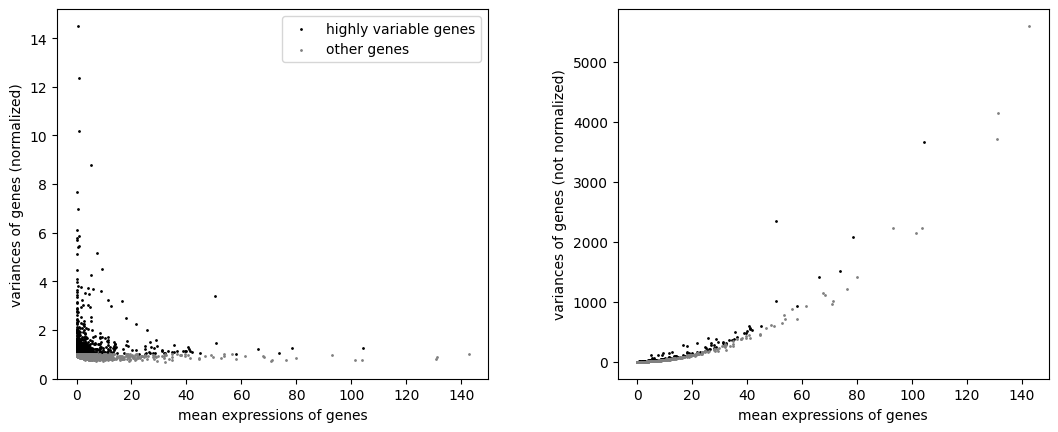

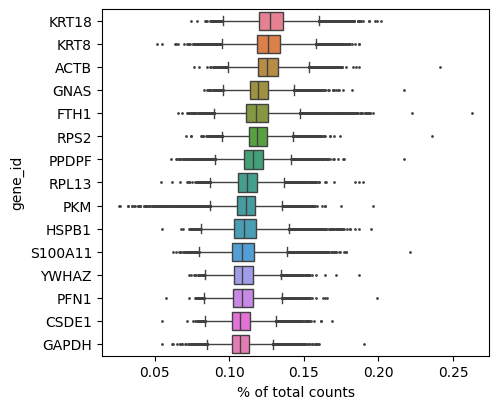

In [3]:
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.highly_variable_genes(adata,show=False)
    plt.savefig(loc+"figures/hvg.pdf", bbox_inches="tight")
with plt.rc_context():  # Use this to set figure params like size and dpi
    sc.pl.highest_expr_genes(adata, show=False,n_top=15)
    plt.savefig(loc+"figures/heg.pdf", bbox_inches="tight")

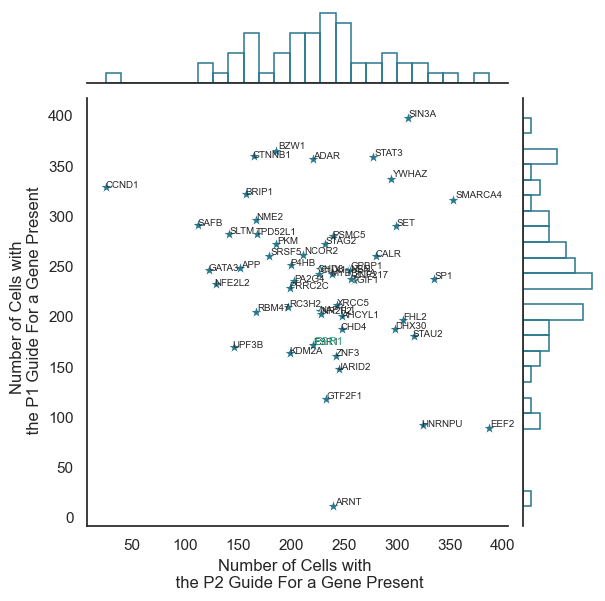

In [5]:
##figure2
#change plot figure
plt.rcParams['figure.figsize'] = [5, 5]
#make prettier
sns.set(style="white")
#check if AP and MP present for each gene
value_counts_p1p2=adata.obs[["perturbation","promoter_type"]].value_counts().reset_index()
value_counts_p1p2=pd.DataFrame(pd.pivot(value_counts_p1p2,index='perturbation', columns="promoter_type",values="count")).reset_index()
sns_plot=sns.jointplot(data=value_counts_p1p2, x="AP",y="MP", color=color5,
    marker="*", s=100, marginal_kws=dict(bins=25, fill=False),
)
for i in range(value_counts_p1p2.shape[0]):
    #randomn number between 0 and 1
    random_1=np.random.uniform(-2,2)
    x_coord=value_counts_p1p2.AP[i]+random_1
    y_coord=value_counts_p1p2.MP[i]+random_1
    name=value_counts_p1p2.perturbation[i]
    plt.text(x=x_coord,y=y_coord,s=name, fontsize=7)
    if value_counts_p1p2.perturbation[i]=="ESR1":
        #style bold
        plt.text(x=value_counts_p1p2.AP[i]+0.3,y=value_counts_p1p2.MP[i]+0.3,s=value_counts_p1p2.perturbation[i], fontsize=8,color=color3)
 
plt.xlabel("Number of Cells with \n the P2 Guide For a Gene Present")
plt.ylabel("Number of Cells with  \n the P1 Guide For a Gene Present")
#save plot in pdf form
output_fig_loc=loc+"figures/4_5_quality_control/"
sns_plot.figure.savefig(output_fig_loc+"cellcount_perprom.pdf")
plt.show()

In [6]:
loc="alt-prom-crispr-fiveprime/"
# specify parameters and distributions to sample from
# genelist=list(pop.cells["perturbation"][(pop.cells["perturbation"]!="control") & (pop.cells["perturbation"]!="NegCtrl3b")].drop_duplicates())
genelist=adata.obs["perturbation"].drop_duplicates().values
#remove non-targeting
genelist=[x for x in genelist if x != "non-targeting"]
hyperparam_list=[]
best_list_list=[]

In [7]:
#calculate the highly variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=1500, flavor="seurat_v3", n_bins=20)

/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [8]:
highlyvariable_genes=adata.var.index[(adata.var["highly_variable"]==True) | (adata.var.index.isin(genelist))]
#add highlyvariable_genes to the targetggene list
adata_sub=adata
adata_sub.obs.index=adata_sub.obs["cell_barcode"]
#subset the highly variable genes
adata_sub=adata[:,highlyvariable_genes]
new_popmatrix_no_duplicates=pd.DataFrame(adata_sub.layers["log1p"])
# new_popmatrix_no_duplicates=pd.DataFrame(adata_sub.layers["sctransform"].todense())
#columns are genes, rows are cells
new_popmatrix_no_duplicates.columns=adata_sub.var.index
new_popmatrix_no_duplicates.index=adata_sub.obs.index
new_popmatrix_no_duplicates_read_count=new_popmatrix_no_duplicates.sum(axis=1)

In [9]:
%%capture
#map a umap, calculate kl diveergence, and rand score
# genelist=["MYBBP1A","ESR1"]
# genelist=["MYBBP1A","ESR1", "PSMC5","BRIP1","STAT3","CHD4"]
#change the backgorun dto white
for gene in genelist:
    print(gene)
    ##list_guides from adata
    list_guides_df=adata_sub.obs[adata_sub.obs["perturbation"]==gene]
    list_guides=list(list_guides_df["guide_identity"].drop_duplicates())
    #find the gene name of interest 
    if not list_guides:
        print("skip")
    if gene not in new_popmatrix_no_duplicates.columns:
        print("skip")
    else:
        #subset cells+in
        # cells_interest=new_popmatrix_no_duplicates[new_popmatrix_no_duplicates.index.isin(list_guides_df["cell_barcode"].drop_duplicates())]
        cells_interest=adata_sub.obs[adata_sub.obs.index.isin(list_guides_df["cell_barcode"].drop_duplicates())]
        # cells_interest["cell_barcode"]=cells_interest.index
        cells_interest=cells_interest.drop_duplicates(subset="cell_barcode")
        column_nopromotergene = [col for col in new_popmatrix_no_duplicates.columns if (('MT' not in col)&('Non' not in col)&('sg' not in col)&('_' not in col))]
        all=new_popmatrix_no_duplicates.loc[cells_interest["cell_barcode"],column_nopromotergene]
        #this creates one list that contains repeating elements one for     
        list_rep=cells_interest["promoter_type"].values
        ##maybe make an if loop that if one of the types are not present then skip....
        list_rep=np.squeeze(pd.DataFrame(list_rep))
        # list_rep_cellcycle=cells_interest["phase"].values
        # list_rep_cellcycle=np.squeeze(pd.DataFrame(list_rep_cellcycle))
        standard_embedding = umap.UMAP(random_state=22).fit_transform(all)   
        ##hyperparam
        hyper_paramlist=hyperparam(df = standard_embedding, list_rep=list_rep)
        best = best_validity(hyper_paramlist)
        clust_alg_eom = hdbscan.HDBSCAN(algorithm='best', alpha=1.0,
                                    approx_min_span_tree=True,
                                    gen_min_span_tree=True, 
                                    cluster_selection_method=best['method'],
                                    metric=best['metric'], 
                                    min_cluster_size=int(best['min_cluster_size']), 
                                    min_samples=int(best['min_samples']), 
                                    allow_single_cluster=False).fit(standard_embedding)
        best_list=pd.DataFrame(best).T
        best_list["gene"]=gene
        best_list_list.append(best_list)
        ##all 
        df_list=pd.DataFrame(hyper_paramlist)
        df_list["gene"]=gene
        hyperparam_list.append(df_list)
        
        ###!!!plotting section !!!!####
        ##individual plotting 
        fig, ax = plt.subplots(1, 1,  dpi= 600, facecolor='none')
        sns.set(style="white",font_scale=0.5,rc={'figure.figsize':(4,3)})
        sns_plot=sns.scatterplot(x=standard_embedding[:,1],y=standard_embedding[:,0],  hue=np.where(list_rep=="MP", "P1", "P2"),ax=ax,palette=palette)

        ###with cell cycle assignment
        # sns_plot=sns.scatterplot(x=standard_embedding[:,1],y=standard_embedding[:,0],  hue=np.where(list_rep=="MP", "P1", "P2"),ax=ax[0],palette=palette)
        # sns_plot=sns.scatterplot(x=standard_embedding[:,1],y=standard_embedding[:,0],  hue=list_rep_cellcycle,ax=ax[1],palette=cellcycle_palette)
        #place the legend outside
        # ax[0].get_legend().remove()
        # ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        #tsne4.kl_divergence_
        ###!!!cluster!!!####
        print(best)
        fig, ax =plt.subplots(1,2)
        sns_plot=sns.scatterplot(x=standard_embedding[:,1],y=standard_embedding[:,0],  hue=np.where(list_rep=="MP", "P1", "P2"),ax=ax[0],size=8, palette=umap_palette)
        sns_plot=sns.scatterplot(x=standard_embedding[:,1],y=standard_embedding[:,0],  hue=clust_alg_eom.labels_,ax=ax[1], size=8, palette=umap_palette)
        #
        sns_plot.figure.savefig("alt-prom-crispr-fiveprime/figures/umap/"+gene+".pdf")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
#hyperparam
dataframe=pd.concat(hyperparam_list)
cols = ['metric','min_cluster_size', 'method','min_samples', 'validity_score', 'n_clusters','randscore','mutualscore' ,'gene']
dataframe.columns=cols
dataframe.to_csv("alt-prom-crispr-fiveprime/files/singlecell_shortread_analysis/hyperparam_cluster.csv")

#metric min_cluster_size method min_samples validity_score n_clusters randscore mutualscore   gene
dataframe=pd.concat(best_list_list)
cols = ['metric','min_cluster_size', 'method','min_samples', 'validity_score', 'n_clusters','randscore','mutualscore','gene']
dataframe.columns=cols
dataframe.to_csv("alt-prom-crispr-fiveprime/files/singlecell_shortread_analysis/best_cluster.csv")


In [11]:
hyperparam_df=pd.read_csv("alt-prom-crispr-fiveprime/files/singlecell_shortread_analysis/hyperparam_cluster.csv",index_col=0)
best_df=pd.read_csv("alt-prom-crispr-fiveprime/files/singlecell_shortread_analysis/best_cluster.csv",index_col=0)
best_df.reset_index(inplace=True)

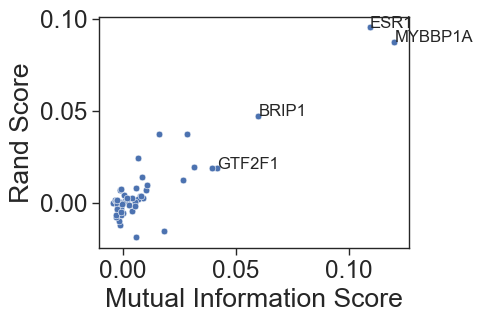

In [12]:
#plot the validity_score randscore and mutualscore
sns.set(style="white")
sns.set_style("ticks")
sns.set_context("paper", font_scale=2)
sns.scatterplot(data=best_df, x="mutualscore", y="randscore", palette=palette)
#label the poiints abopve 0.04 mutual score
for i in range(best_df.shape[0]):
    if best_df.mutualscore[i]>0.04:
        plt.text(best_df.mutualscore[i],best_df.randscore[i],best_df.gene[i], fontsize=12)
#label the two 

plt.xlabel("Mutual Information Score")
plt.ylabel("Rand Score")
plt.savefig("alt-prom-crispr-fiveprime/figures/umap/mutual_rand.pdf") 

In [75]:
adata.obs["gene"][adata.obs["successfulKD"]=="True"]

cell_barcode
GTGTGCGGTTAGTGGG-1       NBN
TCAGATGAGCATCATC-1     PA2G4
GCAATCACACGACGAA-1       PKM
CACACAAAGCTGCAAG-1     SIN3A
GTCACGGGTTAAGTAG-1       SP1
                       ...  
TAGCCGGAGCGTAATA-1     NCOR2
CTTGGCTTCAGCTTAG-1      CHD4
CATATGGAGGTGTTAA-1     GPBP1
TCTCTAAAGGAGCGTT-1     KDM2A
GGGAATGTCTTGACGA-1    CTNNB1
Name: gene, Length: 21657, dtype: category
Categories (50, object): ['ADAR', 'AHCYL1', 'APP', 'ARNT', ..., 'XRCC5', 'YWHAZ', 'ZNF3', 'ZNF217']

In [79]:
vis_gene=["MYBBP1A","ESR1", "GTF2F1","BRIP1","STAT3","CHD4"]
subset_suc=adata.obs["gene"][adata.obs["successfulKD"]=="True"]

subset_suc[subset_suc.isin(vis_gene)].unique()

['CHD4', 'ESR1', 'MYBBP1A', 'STAT3', 'BRIP1', 'GTF2F1']
Categories (50, object): ['ADAR', 'AHCYL1', 'APP', 'ARNT', ..., 'XRCC5', 'YWHAZ', 'ZNF3', 'ZNF217']

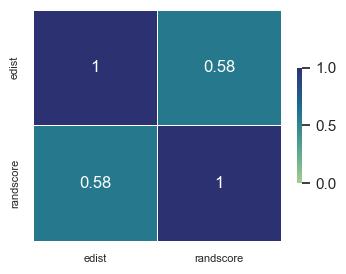

In [13]:
#read in edistance and check the correlation per gene 
edistance=pd.read_csv("alt-prom-crispr-fiveprime/files/singlecell_shortread_analysis/edistance.csv",index_col=0)
edistance["gene"]=edistance.index.str.split("_").str[0]
edistance["promoter"]=edistance.index.str.split("_").str[1]
#merge edistance and best_df
edistance=edistance.merge(best_df, left_on="gene", right_on="gene")
#check correlation between edistance and randscore
#perform spearmans correlation between the two
edistance["edist"]=edistance["edist"].astype(float)
edistance["randscore"]=edistance["randscore"].astype(float)
sns.set(font_scale=1)  # crazy big

sns.heatmap(edistance[['edist','randscore']].corr(method="pearson"), annot=True, cmap="crest", linewidths=.5, vmin=0, vmax=1, cbar_kws={"shrink": .5})
#change the size of text
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.savefig("alt-prom-crispr-fiveprime/figures/edistance_randscore.pdf")